# PyTorch 中级教程1：卷积神经网络（CNN）

In [22]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

print(torch.__version__)

1.12.1


## 硬件配置

In [13]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


## 超参数

In [14]:
# Hyper parameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001


## 准备数据

In [15]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

torch.Size([1, 28, 28])
5


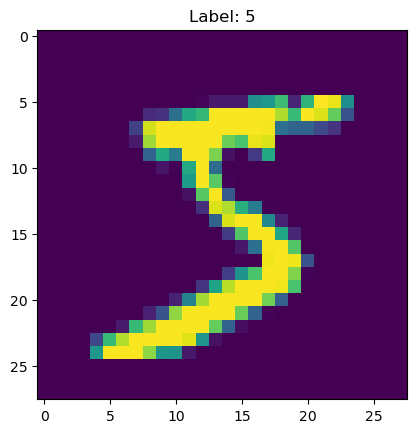

In [23]:
# Fetch one data pair (read data from disk).
image, label = train_dataset[0]
print (image.size())
print (label)

# 显示图片
def show_image(image, label):
    # Convert the tensor image to a numpy array and transpose the dimensions
    tmp_image = image.numpy().transpose((1, 2, 0))

    # Display the image using matplotlib
    plt.imshow(tmp_image)
    plt.title(f'Label: {label}')
    plt.show()
    
show_image(image, label)

## 加载数据

In [16]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

## 定义模型：CNN

In [17]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

## 损失函数、优化器

In [18]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 训练模型

In [19]:
# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/5], Step [100/600], Loss: 0.1049
Epoch [1/5], Step [200/600], Loss: 0.0699
Epoch [1/5], Step [300/600], Loss: 0.1166
Epoch [1/5], Step [400/600], Loss: 0.0917
Epoch [1/5], Step [500/600], Loss: 0.0519
Epoch [1/5], Step [600/600], Loss: 0.0688
Epoch [2/5], Step [100/600], Loss: 0.0058
Epoch [2/5], Step [200/600], Loss: 0.0270
Epoch [2/5], Step [300/600], Loss: 0.0398
Epoch [2/5], Step [400/600], Loss: 0.0497
Epoch [2/5], Step [500/600], Loss: 0.0120
Epoch [2/5], Step [600/600], Loss: 0.0881
Epoch [3/5], Step [100/600], Loss: 0.0174
Epoch [3/5], Step [200/600], Loss: 0.0271
Epoch [3/5], Step [300/600], Loss: 0.0043
Epoch [3/5], Step [400/600], Loss: 0.0372
Epoch [3/5], Step [500/600], Loss: 0.0160
Epoch [3/5], Step [600/600], Loss: 0.0161
Epoch [4/5], Step [100/600], Loss: 0.0107
Epoch [4/5], Step [200/600], Loss: 0.0096
Epoch [4/5], Step [300/600], Loss: 0.0269
Epoch [4/5], Step [400/600], Loss: 0.0430
Epoch [4/5], Step [500/600], Loss: 0.0886
Epoch [4/5], Step [600/600], Loss:

## 测试模型

In [20]:
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


Test Accuracy of the model on the 10000 test images: 98.72 %


## 保存模型

In [21]:
# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')